https://www.kaggle.com/datasets/danielgrijalvas/movies/data

We think one avenue we can go is to use consumer price index for the US (per year) to predict the gross revenue of a movie




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
from dateutil import parser
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Embedding
from keras.optimizers import Adam

2023-12-06 22:53:40.218874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 22:53:40.668985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cpi = pd.read_csv('https://pkgstore.datahub.io/core/cpi/cpi_csv/data/04cb8fe18892497287d23e20d0e1ceb9/cpi_csv.csv')
cpi = cpi.drop(columns = 'Country Code')
cpi = cpi.loc[cpi['Year'] >= 1986]
cpi = cpi.loc[cpi['Country Name'] == 'United States']
cpi = cpi.drop(columns = 'Country Name')
cpi = cpi.set_index('Year')
cpi.head()



,CPI
Year,
1986,50.262433
1987,52.142688
1988,54.233135
1989,56.850970
1990,59.919760


## Three decades of movie data (1986-2014), scraped from IMDb using Python. (220 movies per year, 1986-2014)

In [3]:
movies = pd.read_csv('movies 2.csv')
movies = movies.loc[movies['year'] <= 2014]
movies = movies.loc[movies['country'] == 'United States']

movies = movies.rename(columns={'year': 'Year'})
movies


,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,Top Five,R,Comedy,2014,"December 12, 2014 (United States)",6.4,26000.0,Chris Rock,Chris Rock,Chris Rock,United States,12000000.0,26117471.0,IAC Films,102.0
6638,99 Homes,R,Drama,2014,"October 9, 2015 (United States)",7.1,32000.0,Ramin Bahrani,Ramin Bahrani,Andrew Garfield,United States,8000000.0,1828232.0,Broad Green Pictures,112.0
6639,Black or White,PG-13,Drama,2014,"January 30, 2015 (United States)",6.6,12000.0,Mike Binder,Mike Binder,Kevin Costner,United States,9000000.0,21833967.0,BlackWhite,121.0
6641,Big Stone Gap,PG-13,Comedy,2014,"May 20, 2016 (Spain)",5.7,2800.0,Adriana Trigiani,Adriana Trigiani,Ashley Judd,United States,NaN,1012804.0,Altar Identity Studios,103.0


In [4]:
# combining the CPI and movie datasets
merged_df = pd.merge(movies, cpi, on='Year')

In [5]:
nan_values = merged_df.isna().sum()
print(nan_values)

name          0
rating        5
genre         0
Year          0
released      0
score         0
votes         0
director      0
writer        0
star          0
country       0
budget      741
gross        43
company       6
runtime       1
CPI           0
dtype: int64


## this section drops NAN values

In [6]:
merged_df['success'] = (merged_df['gross'] / merged_df['budget']).apply(lambda x: 1 if x > 2 else 0)

merged_df = merged_df.dropna(subset=['budget'])
nan_count = merged_df['score'].isna().sum()

merged_df.head()

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1


In [7]:
nan_values = merged_df.isna().sum()
print(nan_values)

name         0
rating       4
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross       23
company      1
runtime      1
CPI          0
success      0
dtype: int64


## Cleaning Steps

In [8]:
# Converting 'budget' to numeric
merged_df['budget'] = pd.to_numeric(merged_df['budget'], errors='coerce')
# Previewing the cleaned dataset
merged_df.head()

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1


In [9]:
nan_values = merged_df.isna().sum()
print(nan_values)

name         0
rating       4
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross       23
company      1
runtime      1
CPI          0
success      0
dtype: int64


## EDA

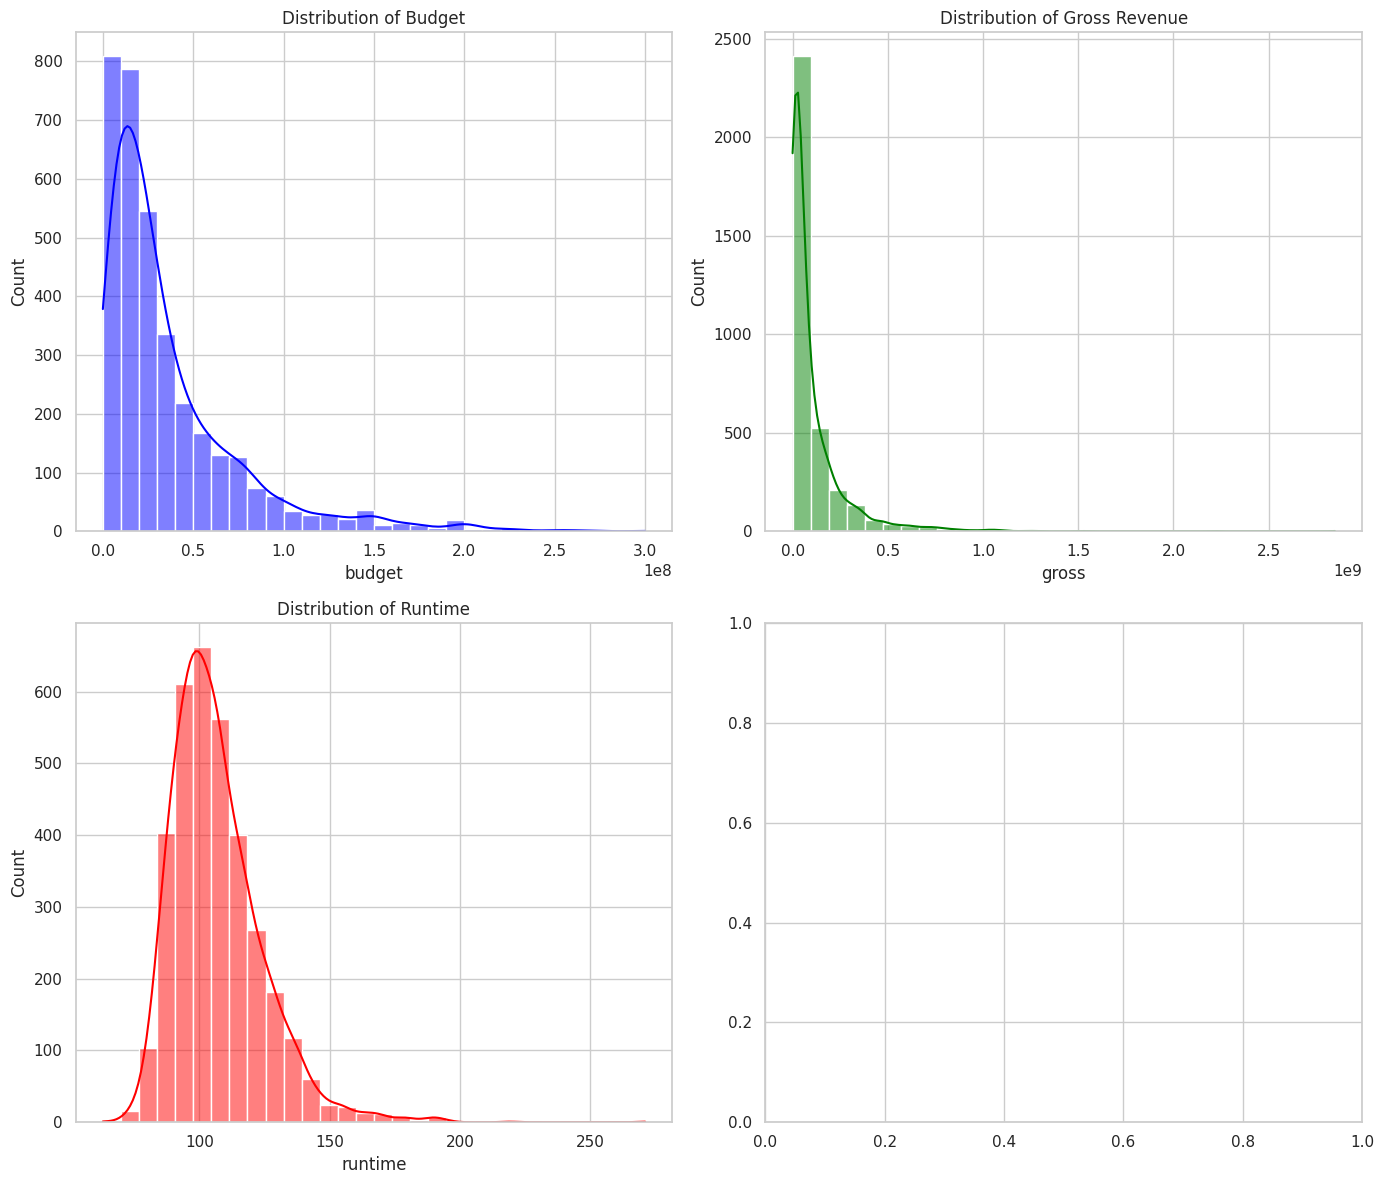

In [10]:
# Setting the style of seaborn
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.histplot(data=merged_df, x='budget', bins=30, ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Budget')
sns.histplot(data=merged_df, x='gross', bins=30, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of Gross Revenue')
sns.histplot(data=merged_df, x='runtime', bins=30, ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Runtime')
plt.tight_layout()
plt.show()


The histograms above provide insights into the distribution of budget, revenue, runtime, and number of production companies:

Budget: Most movies have a budget less than 100 million, with a peak at lower budgets.

Revenue: A similar trend is observed in revenue, with most movies earning less than 100 million.

Runtime: The majority of movies have a runtime around 90 to 120 minutes.

MODEL 1: LINEAR REGRESSION

In [11]:
merged_df['gross_log'] = np.log(merged_df['gross'])
merged_df

# Split the data into training and testing sets
train, test = train_test_split(merged_df, test_size=0.3, random_state=42)

This is predicting gross revenue

In [12]:

#should we of genre and/or rating ... some of them were statistically sig, others were not.

model = smf.ols(formula='gross_log ~ CPI + budget + score',
                 data=train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     546.9
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          3.99e-271
Time:                        22:53:57   Log-Likelihood:                -4327.9
No. Observations:                2416   AIC:                             8664.
Df Residuals:                    2412   BIC:                             8687.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3234      0.246     54.089      0.0

In [13]:

# Import the library that contains all the functions/modules related to the regression model

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)


cols = ['CPI', 'budget', 'score']
VIF(train, cols)

# when we ran VIF, a lot of the movies didn't have a budget included because of (blank) reasons. Our first thoughts were to do score, budget and CPI

CPI       1.108618
budget    1.117373
score     1.008611
dtype: float64

## This is predicting success

In [14]:
model = smf.ols(formula='success ~ CPI + budget + score',
                 data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     77.11
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.21e-47
Time:                        22:53:58   Log-Likelihood:                -1651.8
No. Observations:                2433   AIC:                             3312.
Df Residuals:                    2429   BIC:                             3335.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6573      0.080     -8.187      0.0

In [15]:
merged_df

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success,gross_log
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1,19.694053
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1,17.772266
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1,18.074242
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0,16.222508
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1,17.516306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,Planes: Fire & Rescue,PG,Animation,2014,"July 18, 2014 (United States)",6.0,17000.0,Roberts Gannaway,Roberts Gannaway,Dane Cook,United States,50000000.0,146965787.0,Disneytoon Studios,83.0,108.566932,1,18.805710
4213,Top Five,R,Comedy,2014,"December 12, 2014 (United States)",6.4,26000.0,Chris Rock,Chris Rock,Chris Rock,United States,12000000.0,26117471.0,IAC Films,102.0,108.566932,1,17.078115
4214,99 Homes,R,Drama,2014,"October 9, 2015 (United States)",7.1,32000.0,Ramin Bahrani,Ramin Bahrani,Andrew Garfield,United States,8000000.0,1828232.0,Broad Green Pictures,112.0,108.566932,0,14.418860
4215,Black or White,PG-13,Drama,2014,"January 30, 2015 (United States)",6.6,12000.0,Mike Binder,Mike Binder,Kevin Costner,United States,9000000.0,21833967.0,BlackWhite,121.0,108.566932,1,16.898977


###Random Forest

In [16]:

merged_df['released'] = merged_df['released'].astype(str).apply(lambda x: parser.parse(x, fuzzy=True))

merged_df['year'] = merged_df['released'].dt.year
merged_df['month'] = merged_df['released'].dt.month
merged_df['day'] = merged_df['released'].dt.day

merged_df.head()


,name,rating,genre,Year,released,score,votes,director,writer,star,...,budget,gross,company,runtime,CPI,success,gross_log,year,month,day
0,Top Gun,PG,Action,1986,1986-05-16,6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,...,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1,19.694053,1986,5,16
1,Stand by Me,R,Adventure,1986,1986-08-22,8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,...,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1,17.772266,1986,8,22
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,1986-06-11,7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,...,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1,18.074242,1986,6,11
3,Big Trouble in Little China,PG-13,Action,1986,1986-07-02,7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,...,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0,16.222508,1986,7,2
4,Pretty in Pink,PG-13,Comedy,1986,1986-02-28,6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,...,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1,17.516306,1986,2,28


In [17]:
nan_values = merged_df.isna().sum()
print(nan_values)

name          0
rating        4
genre         0
Year          0
released      0
score         0
votes         0
director      0
writer        0
star          0
country       0
budget        0
gross        23
company       1
runtime       1
CPI           0
success       0
gross_log    23
year          0
month         0
day           0
dtype: int64


In [18]:
merged_df.dropna(inplace=True)
nan_values = merged_df.isna().sum()
print(nan_values)


name         0
rating       0
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross        0
company      0
runtime      0
CPI          0
success      0
gross_log    0
year         0
month        0
day          0
dtype: int64


In [19]:
merged_rf = merged_df

here

In [20]:
# converting day of the week
merged_rf['released'] = pd.to_datetime(merged_rf['released'])

def get_day_of_week(date):
    return date.strftime('%A')

merged_rf['dayofweek'] = merged_rf['released'].apply(get_day_of_week)
rnn_df=merged_df.copy()
print(merged_rf['dayofweek'])

0          Friday
1          Friday
2       Wednesday
3       Wednesday
4          Friday
          ...    
4212       Friday
4213       Friday
4214       Friday
4215       Friday
4217       Friday
Name: dayofweek, Length: 3448, dtype: object


In [23]:
X = merged_rf[['rating', 'genre', 'score', 'votes', 'budget', 'company', 'runtime','CPI', 'month', 'dayofweek']]
y = merged_rf['gross_log']


In [25]:

label_encoder = LabelEncoder()
X['rating'] = label_encoder.fit_transform(X['rating'])
X['genre'] = label_encoder.fit_transform(X['genre'])
X['company'] = label_encoder.fit_transform(X['company'])
X['dayofweek'] = label_encoder.fit_transform(X['dayofweek'])

X


/tmp/ipykernel_986576/172531724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rating'] = label_encoder.fit_transform(X['rating'])
/tmp/ipykernel_986576/172531724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['genre'] = label_encoder.fit_transform(X['genre'])
/tmp/ipykernel_986576/172531724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,rating,genre,score,votes,budget,company,runtime,CPI,month,dayofweek
0,3,0,6.9,306000.0,15000000.0,649,110.0,50.262433,5,0
1,5,1,8.1,374000.0,8000000.0,258,89.0,50.262433,8,0
2,4,4,7.8,330000.0,6000000.0,649,103.0,50.262433,6,6
3,4,0,7.3,128000.0,25000000.0,800,99.0,50.262433,7,6
4,4,4,6.8,76000.0,9000000.0,649,97.0,50.262433,2,0
...,...,...,...,...,...,...,...,...,...,...
4212,3,2,6.0,17000.0,50000000.0,309,83.0,108.566932,7,0
4213,5,4,6.4,26000.0,12000000.0,462,102.0,108.566932,12,0
4214,5,6,7.1,32000.0,8000000.0,164,112.0,108.566932,10,0
4215,4,6,6.6,12000.0,9000000.0,139,121.0,108.566932,1,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,rating,genre,score,votes,budget,company,runtime,CPI,month,dayofweek
59,5,0,5.8,4700.0,18000000.0,681,115.0,50.262433,4,0
2328,4,1,5.6,31000.0,13000000.0,113,84.0,81.202568,8,0
4116,4,0,5.6,302000.0,210000000.0,649,165.0,108.566932,6,0
3065,5,6,8.2,535000.0,25000000.0,650,158.0,95.086992,1,0
3801,5,0,7.4,545000.0,30000000.0,794,113.0,105.291505,9,0
...,...,...,...,...,...,...,...,...,...,...
1592,5,4,5.4,14000.0,13000000.0,809,87.0,71.931229,8,0
1641,5,6,5.8,14000.0,47000000.0,600,108.0,71.931229,2,0
1850,5,5,6.5,81000.0,60000000.0,823,107.0,74.755433,6,0
1284,3,6,7.5,7400.0,3000000.0,506,103.0,67.975813,2,0


In [27]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.1016243064283615
R-squared: 0.6805916148993995


In [28]:
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15]
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1, n_iter=20)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}") #Best Parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 80}
print(f"Best Negative Mean Squared Error: {best_score}") #Best Negative Mean Squared Error: -0.9763526515834959



Best Parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 70}
Best Negative Mean Squared Error: -0.9814629367390534


In [29]:
rf_model = RandomForestRegressor(n_estimators=400, min_samples_split= 10, min_samples_leaf = 5, max_depth = 80)

rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}") #Mean Squared Error: 1.0698823766350398
print(f"R-squared: {r_squared}") #R-squared: 0.6897949689613052




Mean Squared Error: 1.074250008778221
R-squared: 0.6885286040840723


# RNN

In [30]:
rnn_df

,name,rating,genre,Year,released,score,votes,director,writer,star,...,gross,company,runtime,CPI,success,gross_log,year,month,day,dayofweek
0,Top Gun,PG,Action,1986,1986-05-16,6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,...,357288178.0,Paramount Pictures,110.0,50.262433,1,19.694053,1986,5,16,Friday
1,Stand by Me,R,Adventure,1986,1986-08-22,8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,...,52287414.0,Columbia Pictures,89.0,50.262433,1,17.772266,1986,8,22,Friday
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,1986-06-11,7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,...,70720215.0,Paramount Pictures,103.0,50.262433,1,18.074242,1986,6,11,Wednesday
3,Big Trouble in Little China,PG-13,Action,1986,1986-07-02,7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,...,11100577.0,Twentieth Century Fox,99.0,50.262433,0,16.222508,1986,7,2,Wednesday
4,Pretty in Pink,PG-13,Comedy,1986,1986-02-28,6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,...,40479480.0,Paramount Pictures,97.0,50.262433,1,17.516306,1986,2,28,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,Planes: Fire & Rescue,PG,Animation,2014,2014-07-18,6.0,17000.0,Roberts Gannaway,Roberts Gannaway,Dane Cook,...,146965787.0,Disneytoon Studios,83.0,108.566932,1,18.805710,2014,7,18,Friday
4213,Top Five,R,Comedy,2014,2014-12-12,6.4,26000.0,Chris Rock,Chris Rock,Chris Rock,...,26117471.0,IAC Films,102.0,108.566932,1,17.078115,2014,12,12,Friday
4214,99 Homes,R,Drama,2014,2015-10-09,7.1,32000.0,Ramin Bahrani,Ramin Bahrani,Andrew Garfield,...,1828232.0,Broad Green Pictures,112.0,108.566932,0,14.418860,2015,10,9,Friday
4215,Black or White,PG-13,Drama,2014,2015-01-30,6.6,12000.0,Mike Binder,Mike Binder,Kevin Costner,...,21833967.0,BlackWhite,121.0,108.566932,1,16.898977,2015,1,30,Friday


In [32]:

X = rnn_df[['rating', 'genre', 'score', 'votes', 'budget', 'company', 'runtime','CPI', 'month', 'dayofweek']]
X['rating'] = label_encoder.fit_transform(X['rating'])
X['genre'] = label_encoder.fit_transform(X['genre'])
X['company'] = label_encoder.fit_transform(X['company'])
X['dayofweek'] = label_encoder.fit_transform(X['dayofweek'])

y =  rnn_df['gross_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

/tmp/ipykernel_986576/1684573305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rating'] = label_encoder.fit_transform(X['rating'])
/tmp/ipykernel_986576/1684573305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['genre'] = label_encoder.fit_transform(X['genre'])
/tmp/ipykernel_986576/1684573305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,rating,genre,score,votes,budget,company,runtime,CPI,month,dayofweek
59,5,0,5.8,4700.0,18000000.0,681,115.0,50.262433,4,0
2328,4,1,5.6,31000.0,13000000.0,113,84.0,81.202568,8,0
4116,4,0,5.6,302000.0,210000000.0,649,165.0,108.566932,6,0
3065,5,6,8.2,535000.0,25000000.0,650,158.0,95.086992,1,0
3801,5,0,7.4,545000.0,30000000.0,794,113.0,105.291505,9,0
...,...,...,...,...,...,...,...,...,...,...
1592,5,4,5.4,14000.0,13000000.0,809,87.0,71.931229,8,0
1641,5,6,5.8,14000.0,47000000.0,600,108.0,71.931229,2,0
1850,5,5,6.5,81000.0,60000000.0,823,107.0,74.755433,6,0
1284,3,6,7.5,7400.0,3000000.0,506,103.0,67.975813,2,0


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [148]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=1000, batch_size=200, validation_data=(X_test_scaled, y_test),verbose=0)

test_loss = model.evaluate(X_test_scaled, y_test)
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}") 
print(f"R-squared: {r_squared}") 



22/22 [==============================] - 0s 957us/step
Mean Squared Error: 0.9812039148894494
R-squared: 0.7155066785650969


epoch= 100. batch size 32
Mean Squared Error: 1.0740076667466656
R-squared: 0.6885988694880665

epoch= 1000. batch size 200 (optimal)
Mean Squared Error: 0.9812039148894494
R-squared: 0.7155066785650969

epoch= 5000. batch size 400
Mean Squared Error: 1.2119616751978026
R-squared: 0.6486000542836403

# Time Series

In [210]:
time_series_df=rnn_df.copy()
time_series_df=time_series_df[['released','gross']]
time_series_df['released'] = pd.to_datetime(time_series_df['released'])
time_series_df = time_series_df.sort_values(by='released')
time_series_df['year'] = time_series_df['released'].dt.year
avg_gross_per_year = time_series_df.groupby('year')['gross'].mean()
avg_gross_per_year_df = avg_gross_per_year.reset_index()
avg_gross_per_year_df.columns = ['year', 'avg_gross']

In [211]:
avg_gross_per_year_df

,year,avg_gross
0,1986,2.806364e+07
1,1987,3.530763e+07
2,1988,3.836062e+07
3,1989,4.902162e+07
4,1990,6.348587e+07
5,1991,5.294106e+07
6,1992,5.754116e+07
7,1993,5.766866e+07
8,1994,7.178307e+07
9,1995,6.661914e+07


In [212]:
year = avg_gross_per_year_df['year']

print(year.unique())

[1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2019]


In [213]:
def plot_entire_series(x, y, tittle='',**kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.title(tittle)
    plt.show()
    return None
def plot_last_fifty(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.scatter(x[-50:], y[-50:], linewidth=3, color='black')
    plt.plot(x[-50:], y[-50:], linewidth=3, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x[-50:], value[-50:], linewidth=3, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.show()
    
    return None
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

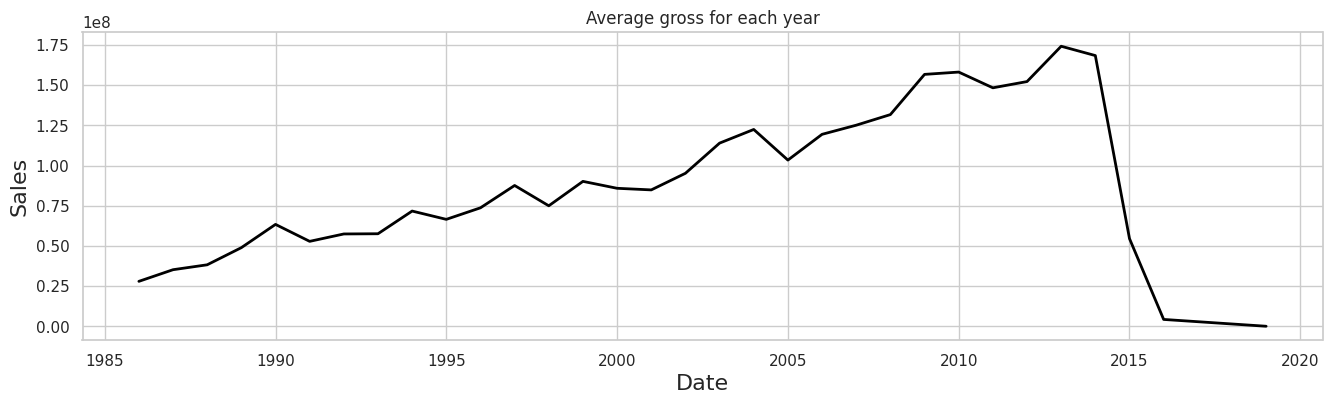

In [214]:
plot_entire_series(avg_gross_per_year_df['year'],avg_gross_per_year_df['avg_gross'],'Average gross for each year')


In [215]:
time_train = avg_gross_per_year_df[avg_gross_per_year_df['year'] < 2010]
time_test  = avg_gross_per_year_df[avg_gross_per_year_df['year'] >= 2010]
time_train['AvgGrossLastYear'] = time_train['avg_gross'].shift(1)
time_test['AvgGrossLastYear'] = time_test['avg_gross'].shift(1)
x = time_train['year'].to_numpy()
y = time_train['avg_gross'].to_numpy()
print(time_train.shape,time_test.shape)

(24, 3) (8, 3)


/tmp/ipykernel_986576/38302310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_train['AvgGrossLastYear'] = time_train['avg_gross'].shift(1)
/tmp/ipykernel_986576/38302310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_test['AvgGrossLastYear'] = time_test['avg_gross'].shift(1)


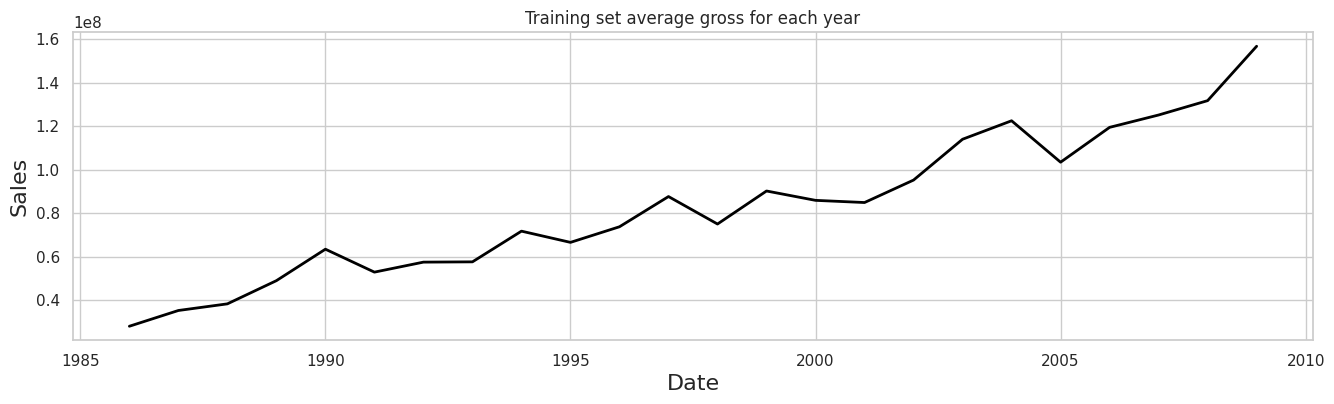

In [216]:

plot_entire_series(x,y,'Training set average gross for each year')

# Auto-Regressive Model

In [217]:
ar1 = smf.ols(formula='avg_gross ~ AvgGrossLastYear', data=time_train).fit()
print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_gross   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.91e-11
Time:                        23:32:45   Log-Likelihood:                -404.44
No. Observations:                  23   AIC:                             812.9
Df Residuals:                      21   BIC:                             815.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.478e+06   6.59e+06  

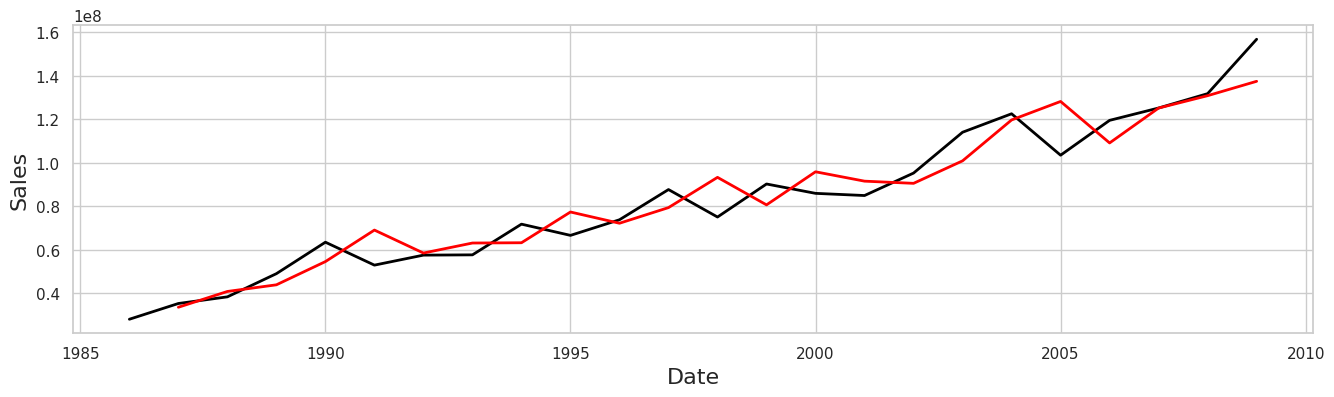

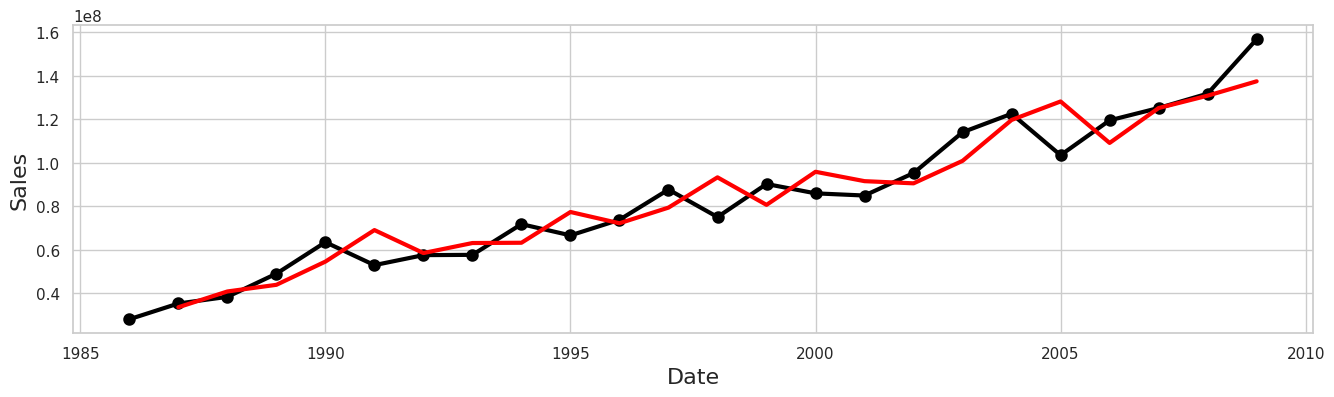

In [218]:
y_pred = ar1.predict(time_train)
plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred)

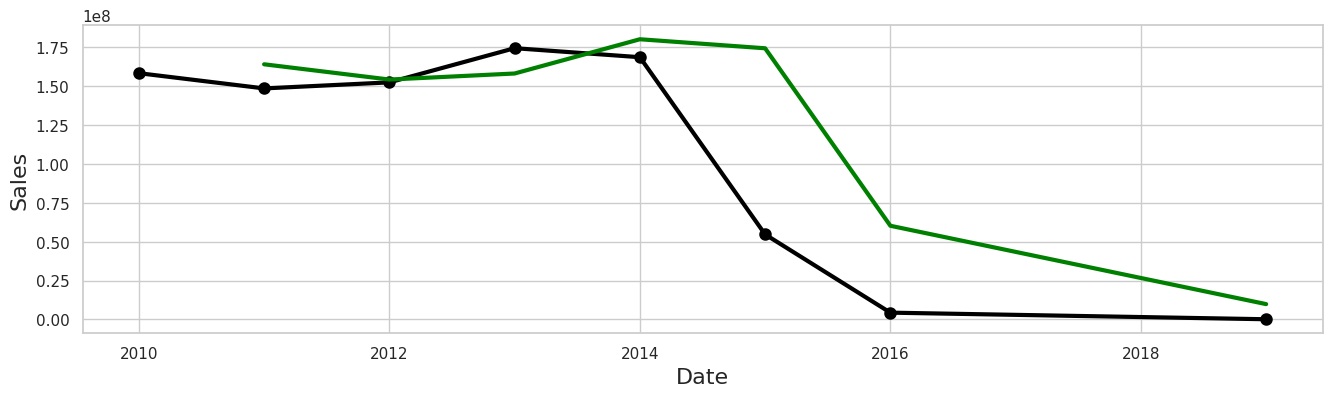

In [219]:
y_pred = ar1.predict(time_test)
x_test = time_test['year'].to_numpy()
y_test = time_test['avg_gross'].to_numpy()
plot_last_fifty(x_test, y_test, green=y_pred)

In [220]:
print('Auto-regressive Model OSR2:', round(OSR2(ar1, time_test, y_test, y), 5))

Auto-regressive Model OSR2: 0.59046


# Higher-order Auto-regressive Model

In [226]:
time_train['AvgGrossLastTwoYear'] = time_train['avg_gross'].shift(2)
time_test['AvgGrossLastTwoYear'] = time_test['avg_gross'].shift(2)
ar2 = smf.ols(formula='avg_gross ~ AvgGrossLastYear + AvgGrossLastTwoYear', data=time_train).fit()
print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_gross   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     77.30
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           7.46e-10
Time:                        23:35:31   Log-Likelihood:                -385.73
No. Observations:                  22   AIC:                             777.5
Df Residuals:                      19   BIC:                             780.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.733e+06   7

/tmp/ipykernel_986576/3509422340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_train['AvgGrossLastTwoYear'] = time_train['avg_gross'].shift(2)
/tmp/ipykernel_986576/3509422340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_test['AvgGrossLastTwoYear'] = time_test['avg_gross'].shift(2)


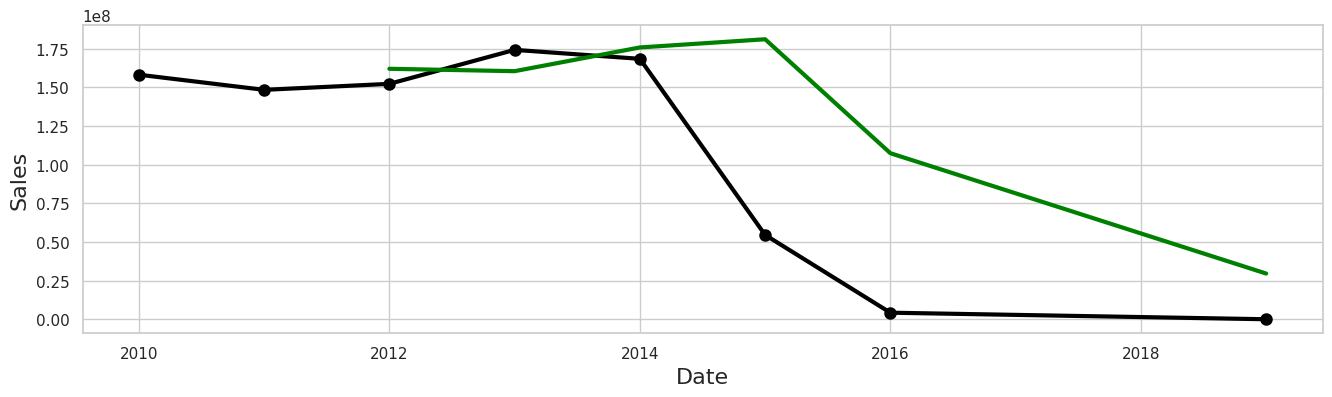

In [227]:
y_pred = ar2.predict(time_test)
x_test = time_test['year'].to_numpy()
y_test = time_test['avg_gross'].to_numpy()
plot_last_fifty(x_test, y_test, green=y_pred)

In [232]:
print('Higher-order Auto-regressive Model OSR2:', round(OSR2(ar2, time_test, y_test, y), 5))

Higher-order Auto-regressive Model OSR2: 0.37171
